In [1]:
 #!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to c:\users\sswarupa\appdata\local\temp\1\pip-req-build-34t3wh90
  Resolved https://github.com/ourownstory/neural_prophet.git to commit e57badfcb1459ad52c338d69e54a5d43831f90e9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Created wheel for neuralprophet: filename=neuralprophet-0.3.3-py3-none-any.whl size=81145 sha256=4d3d0d0bb919c1862dcb718f31a93d517b3227b3b0e1330110fec3fe397d2ece
  Stored in directory: C:\Users\sswarupa\AppData\Local\Temp\1\pip-ephem-wheel-cache-cx0lh3j1\wheels\e1\cd\06\b4fbd2d470da25a72559f6b32ec4bc628917dde3bf3db99491
S

  Running command git clone -q https://github.com/ourownstory/neural_prophet.git 'C:\Users\sswarupa\AppData\Local\Temp\1\pip-req-build-34t3wh90'
  Running command git submodule update --init --recursive -q


In [2]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [8]:
df_2018 = pd.read_csv('dallas_solar_energy_2018.csv',index_col=False)
df_2019 = pd.read_csv('dallas_solar_energy_2019.csv',index_col=False)
df_2020 = pd.read_csv('dallas_solar_energy_2020.csv',index_col=False)
df_solar_raw = df_2018.append(df_2019, ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\AppData\Local\Temp\1\ipykernel_28336\3205678410.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_solar_raw = df_2018.append(df_2019, ignore_index=True)



In [9]:
df_solar = df_solar_raw[['timestamp_solar','ghi']]
df_solar['Datetime'] = df_solar['timestamp_solar'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_solar= df_solar.drop(['timestamp_solar'],axis=1)
df_solar['Datetime'] = pd.to_datetime(df_solar['Datetime'])


WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\AppData\Local\Temp\1\ipykernel_28336\1966979733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solar['Datetime'] = df_solar['timestamp_solar'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S'))



In [10]:
df_solar.rename(columns = {'Datetime':'ds', 'ghi':'y'}, inplace = True)
df_solar['ds'] = pd.to_datetime(df_solar['ds'])

Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

From the start, we know that the sun intensity depends on the time of day and season in the year. Further, we know that the daily peak intensity is proportional to the season. As of now, neither Prophet nor NeuralProphet can multiply two seasonalities, thus, the peak will bee to low in summer and may turn negative in winter. Not ideal, but ok for a first attempt.

In [11]:
m = NeuralProphet(
    yearly_seasonality=3,
    weekly_seasonality=False,
    daily_seasonality=8,
    growth="off",
    learning_rate=0.1,
)
df_train, df_test = m.split_df(df_solar, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [12]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
76,0.018317,102.509185,141.550842,0.0,0.014428,99.394063,126.222095


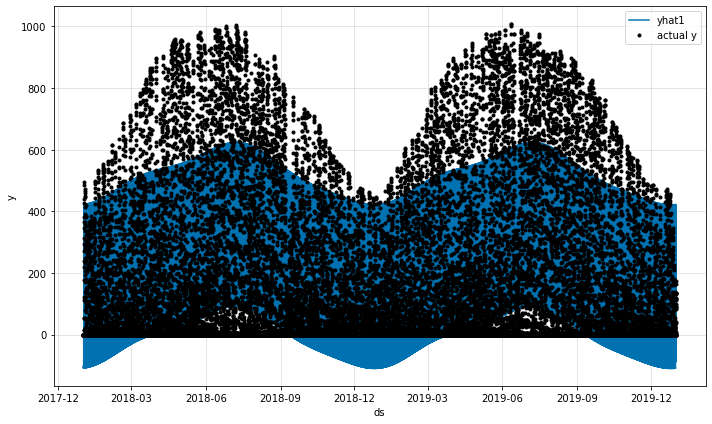

In [13]:
forecast = m.predict(df_solar)
fig = m.plot(forecast)

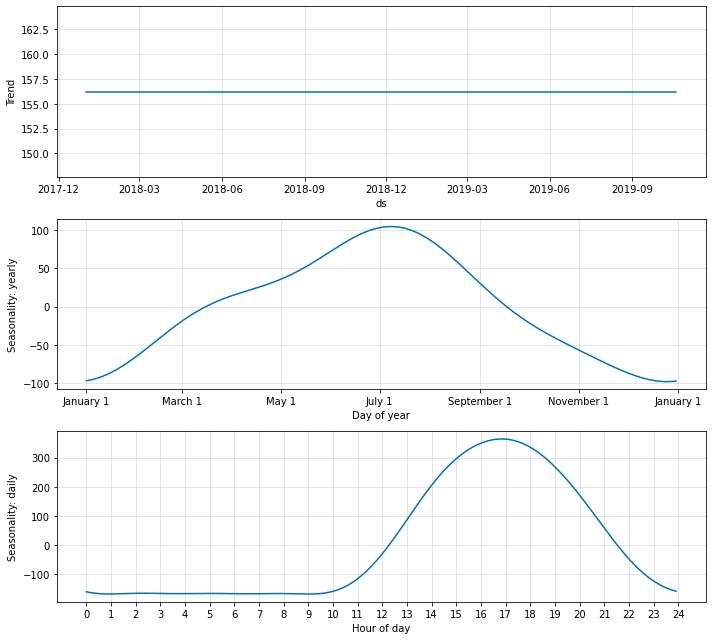

In [14]:
fig_param = m.plot_parameters()

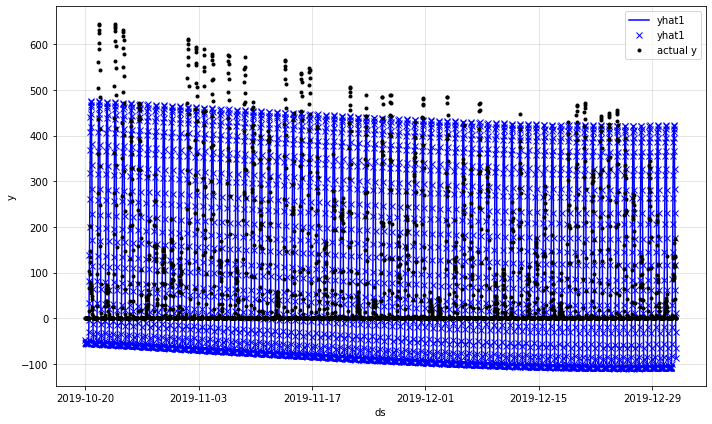

In [15]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

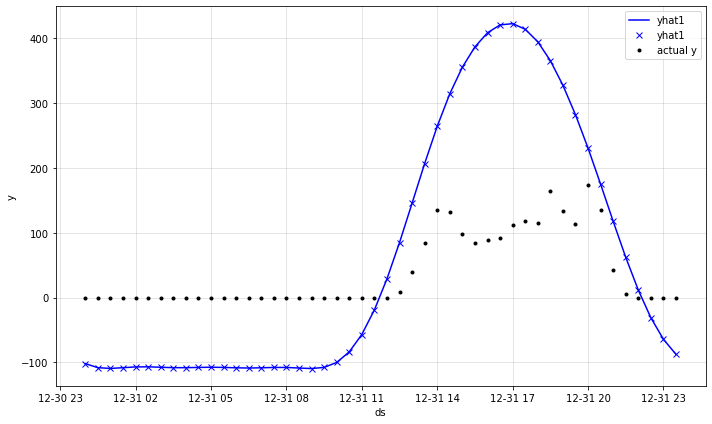

In [16]:
fig_prediction = m.plot(forecast[-48:])

In this second section, we will train a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). We can train this forecaster considering the privious 24 steps and disabling trend and seasonality.

The paramters that we can modify are the number of lags and the AR sparsity.

In [17]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(df_solar, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [18]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
91,0.003959,38.356288,64.867641,0.0,0.001227,23.221052,36.790935


WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:2348: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:1649: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



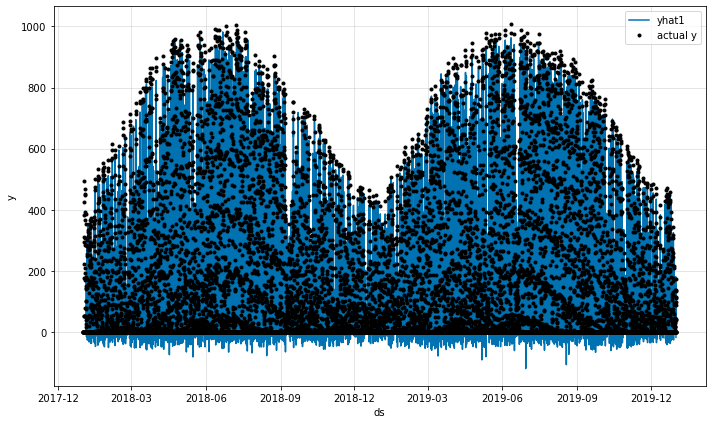

In [19]:
forecast = m.predict(df_solar)
fig = m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:2348: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:1649: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



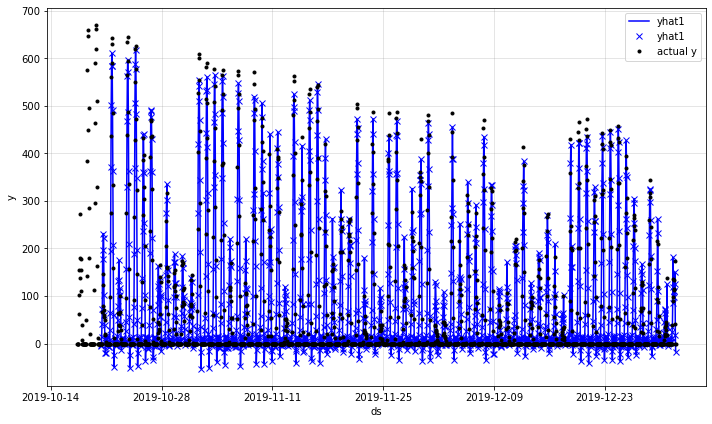

In [20]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

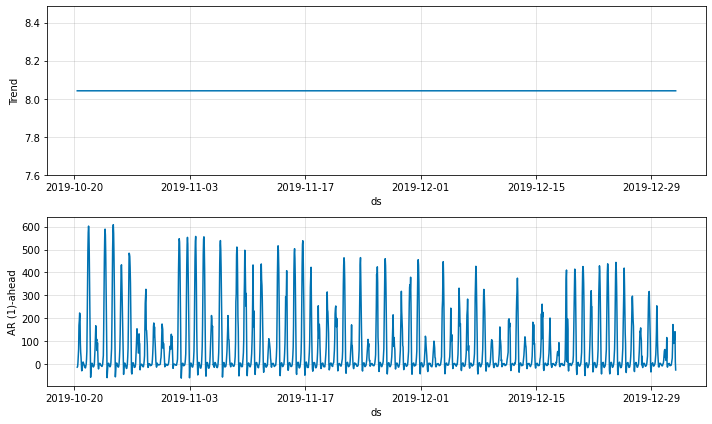

In [21]:
fig_comp = m.plot_components(forecast)

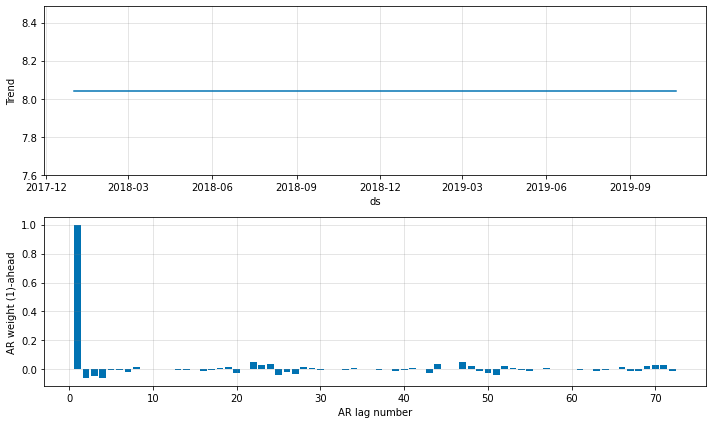

In [22]:
fig_param = m.plot_parameters()

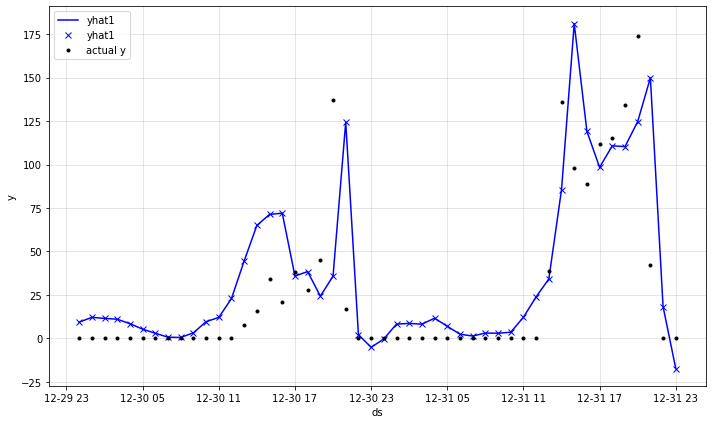

In [23]:
fig_prediction = m.plot(forecast[-48:])

Sparsifying the AR coefficients: 

By setting an ar_reg > 0 we can reduce the number of non-zero AR coefficients.

In [24]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(df_solar, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [25]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
91,0.00404,39.38265,65.517097,0.000501,0.001309,23.825966,37.979186


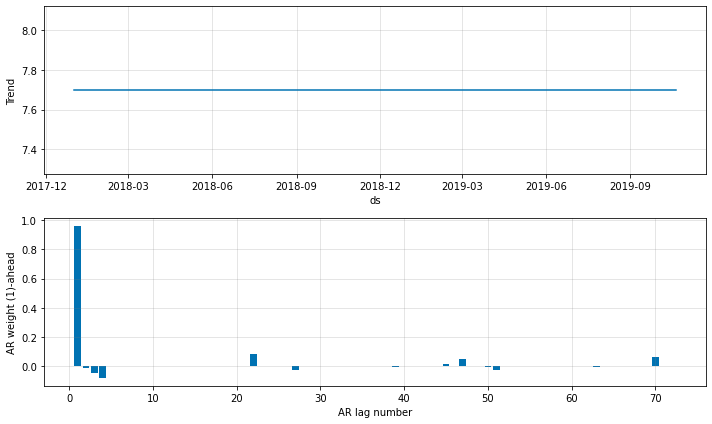

In [26]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

1-step ahead forecast with Auto-Regression including Integration  

Next, we will add the differences of the series as a lagged covariate. This basically extends the model from AR to ARI, where the I stands for 'integrated' time series.

In [27]:
df = df_solar.copy(deep=True)
df["I"] = np.append(0, df_solar["y"].values[1:] - df_solar["y"].values[:-1])
df.tail(3)

,y,ds,I
35037,0.0,2019-12-31 22:30:00,0.0
35038,0.0,2019-12-31 23:00:00,0.0
35039,0.0,2019-12-31 23:30:00,0.0


In [28]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    learning_rate=0.01,
)
m = m.add_lagged_regressor("I", normalize="standardize")
df_train, df_test = m.split_df(df, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [29]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
91,0.003878,37.846763,64.086966,0.0,0.001209,22.991365,36.528335


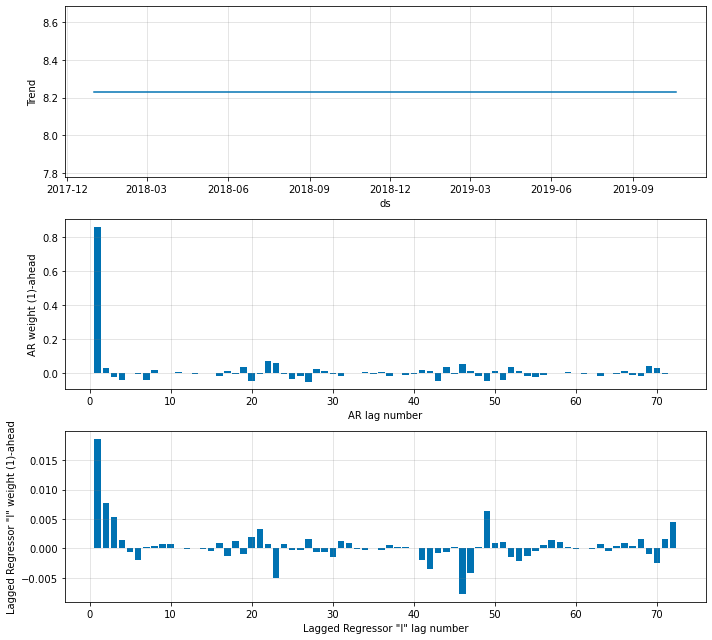

In [30]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

1 step ahead forecast with AR-Net: Using a Neural Network 
    
There is something to consider here, if we consider a neural network with at least one hidden layer: Learning Rate matters when training a Neural Network.

    
For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.
An easy way to void this issue is to set the learning rate at a low enough value, likely around 0.01 to 0.001.

In [32]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=8,
    learning_rate=0.003,
)

df = df_solar.copy(deep=True)
df["I"] = np.append(0, df_solar["y"].values[1:] - df_solar["y"].values[:-1])
df_train, df_test = m.split_df(df, freq='H', valid_p = 0.10)
m = m.add_lagged_regressor("I", normalize="standardize")
metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [33]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
91,0.002487,25.70946,50.760889,0.0,0.000864,15.435331,30.907144


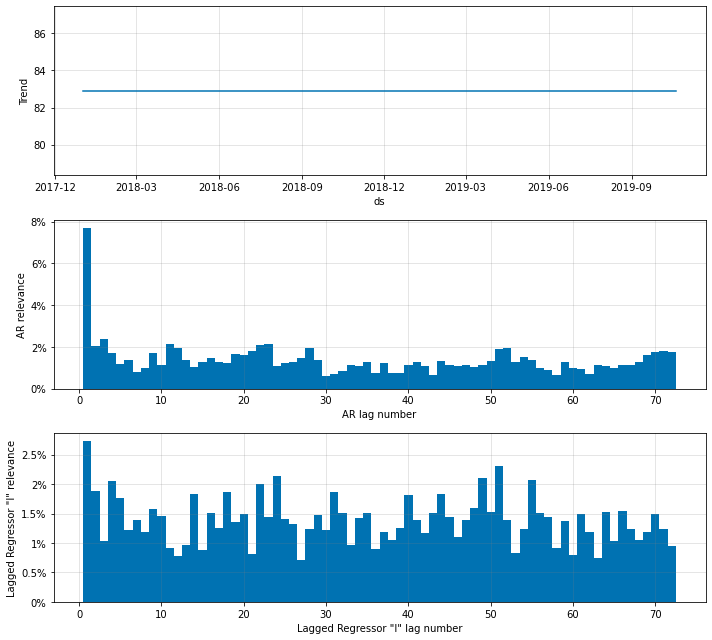

In [34]:
fig = m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:2348: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - C:\Users\sswarupa\Anaconda3\lib\site-packages\neuralprophet\forecaster.py:1649: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



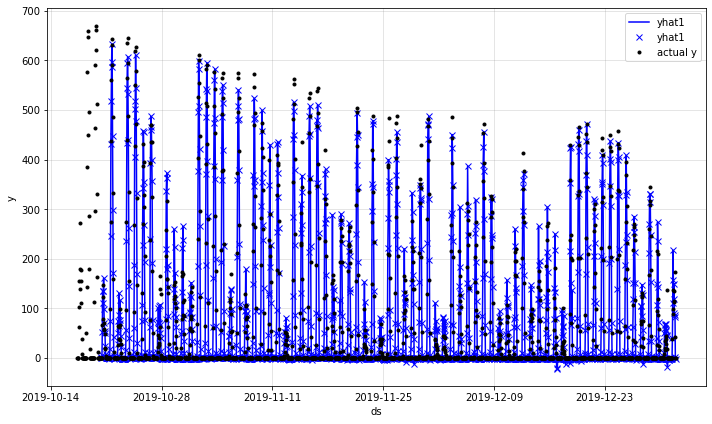

In [35]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
forecast = m.predict(df_test)
fig = m.plot(forecast)

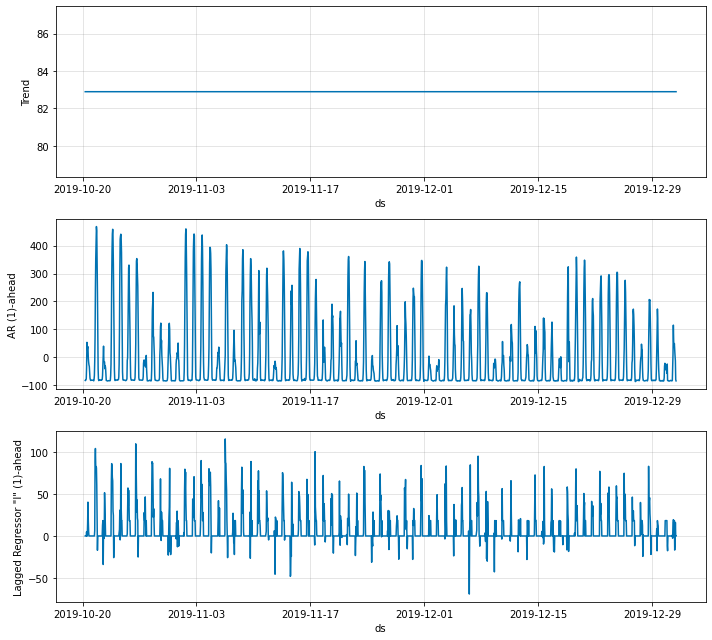

In [36]:
fig_comp = m.plot_components(forecast)

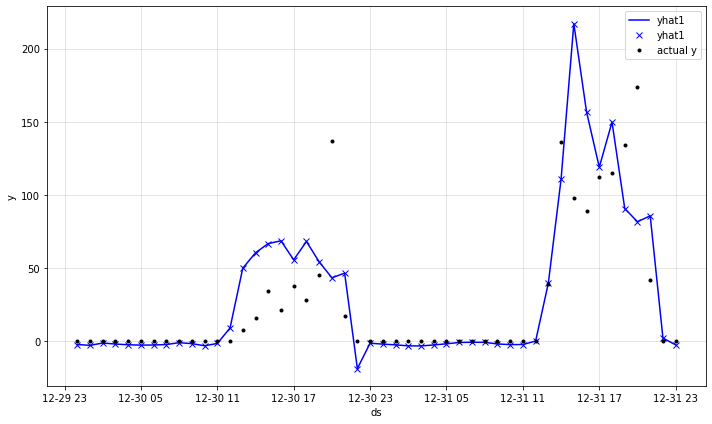

In [37]:
fig_prediction = m.plot(forecast[-48:])